# <div align="center"> Client Case: OG&Gym</div>
## <div align="center"> Analytics in Business</div>
### <div align="center"> Appendix</div>

<div align="center">25/1/2021</div>

<br><div align="center"> By Group A3: </div>
<div align="center"> Jiaqi Chen, Yuxi Fu, Jiaxuan Lyu, Maria Tsotalou, Qian Zhang </div>

### Initialisation

In [1]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt  
import seaborn as sns

In [16]:
### Initial data loading 
subscriptions = pd.read_csv( 'subscriptionsdataFINAL.csv') 
subscriptions_Q5 = subscriptions.copy()

In [3]:
visitation_part1 = pd.read_csv('visitationdataPART1.csv') 
visitation_part2 = pd.read_csv('visitationdataPART2.csv') 

### 1. Revenue 

In [4]:
#Membership net flow
def calculate_revenue_flexible(Date,net_member):
    date_while_price_changed = pd.Timestamp('2016-01-01') 
    if Date < date_while_price_changed:
        return net_member * 25.99
    elif Date >= date_while_price_changed:
        return net_member * 30.99
    
def calculate_revenue_standard(Date,net_member):
    date_while_price_changed = pd.Timestamp('2016-01-01') 
    if Date < date_while_price_changed:
        return net_member * 20.99
    elif Date >= date_while_price_changed:
        return net_member * 26.99 

def data_manipulation_for_revenue(subscriptions):
    df = subscriptions.copy()
    
    df['Join Date'] =  pd.to_datetime(df['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    df['Join_year'] = pd.DatetimeIndex(df['Join Date']).year
    df['End Date'] =  pd.to_datetime(df['End Date'].str.upper(), format='%b-%y', yearfirst=False)
    
    date_min = min (df['Join Date'].min(),df['End Date'].min())
    date_max = max (df['Join Date'].max(),df['End Date'].max())
    df['Duration'] = np.where(df['End Date'].isna(), 
                                         (date_max - df['Join Date']), 
                                         (df['End Date'] - df['Join Date']) )
    df['Duration'] = (df['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    df.loc[(df.Duration <= 2),'Duration']=2
    def extend_early_standard_to_three_months(join_date,duration):
        return join_date + pd.DateOffset(months=duration)
    df['End Date']=df.apply(lambda row: extend_early_standard_to_three_months(row['Join Date'], row['Duration']),axis=1)
    df=df.drop(columns=['Duration'])
    
    
    member_joined_data = df.groupby(['Join Date','Subscription Type']).size().reset_index(name='Number_of_member_joined')
    member_joined_data = member_joined_data.rename(columns={'Join Date': "Date"})

    member_left_data = df.groupby(['End Date','Subscription Type']).size().reset_index(name='Number_of_member_left')
    member_left_data=member_left_data.rename(columns={'End Date': "Date"})
    member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)

    member_data = pd.merge(member_joined_data,member_left_data,on = ['Subscription Type','Date'],how='outer').sort_index().replace({np.nan:0})
    member_data['net_member'] = member_data['Number_of_member_joined'] - member_data['Number_of_member_left'] 
    member_data = member_data.drop(columns = ['Number_of_member_joined', 'Number_of_member_left'])

    Members_per_subscription = pd.DataFrame(member_data.groupby(['Date', 'Subscription Type']).sum())
    Cumulative_Members = Members_per_subscription.cumsum().reset_index()
    Cumulative_Members = Cumulative_Members.rename(columns={"net_member": "Cumulative members"}) 
    
    Cumulative_Members_revenue = Cumulative_Members.copy()
    Cumulative_Members_revenue['Flexible_revenue'] = Cumulative_Members[Cumulative_Members["Subscription Type"]=="Flexible"].apply(lambda row: calculate_revenue_flexible(row['Date'], row['Cumulative members']),axis=1)
    Cumulative_Members_revenue['Standard_revenue'] = Cumulative_Members[Cumulative_Members["Subscription Type"]=="Standard"].apply(lambda row: calculate_revenue_standard(row['Date'], row['Cumulative members']),axis=1)
    
    Cumulative_Members_revenue_total = Cumulative_Members_revenue.copy()
    Cumulative_Members_revenue_total = Cumulative_Members_revenue_total.groupby('Date').sum()
    Cumulative_Members_revenue_total['Total revenue'] = Cumulative_Members_revenue_total['Flexible_revenue'] 
    + Cumulative_Members_revenue_total['Standard_revenue']

    Cumulative_Members_revenue_total['Revenue_growth'] = Cumulative_Members_revenue_total['Total revenue'].pct_change()

    Cumulative_Members_revenue_total.reset_index(inplace=True)
    #Cumulative_revenue_growth.reset_index(inplace=True)

    Cumulative_revenue_yearly = Cumulative_Members_revenue_total.copy()
    Cumulative_revenue_yearly = Cumulative_revenue_yearly.drop(columns=['Cumulative members']) 

    Cumulative_revenue_yearly['year'] = pd.DatetimeIndex(Cumulative_revenue_yearly['Date']).year
    Cumulative_revenue_yearly = pd.DataFrame(Cumulative_revenue_yearly.groupby('year').sum() )
    Cumulative_revenue_yearly = Cumulative_revenue_yearly.drop([2019])
    Cumulative_revenue_yearly['Revenue_growth'] = Cumulative_revenue_yearly['Total revenue'].pct_change()
    Cumulative_revenue_yearly.reset_index(inplace=True)

    return Cumulative_Members_revenue_total, Cumulative_revenue_yearly

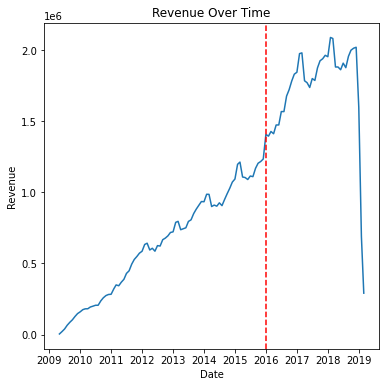

In [5]:
def plot_monthly_revenue():
    plt.figure(figsize=(6,6))
    Cumulative_Members_revenue_total, Cumulative_revenue_yearly = data_manipulation_for_revenue(subscriptions)
    plt.plot(Cumulative_Members_revenue_total['Date'], Cumulative_Members_revenue_total['Total revenue'])
    plt.title('Revenue Over Time')
    plt.ylabel('Revenue')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
                                                                                        
plot_monthly_revenue()

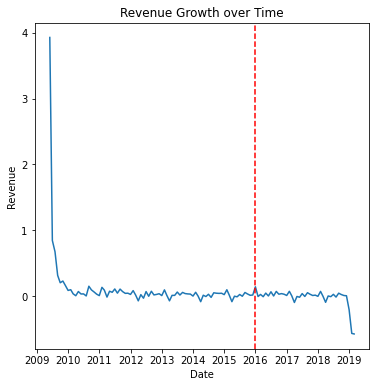

In [6]:
def plot_growth_yearly_mothly():
    Cumulative_Members_revenue_total, Cumulative_revenue_yearly = data_manipulation_for_revenue(subscriptions)
    plt.figure(figsize=(6,6))
    plt.plot(Cumulative_Members_revenue_total['Date'], Cumulative_Members_revenue_total['Revenue_growth'])
    plt.title('Revenue Growth over Time')
    plt.ylabel('Revenue')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
                                                                         
plot_growth_yearly_mothly()

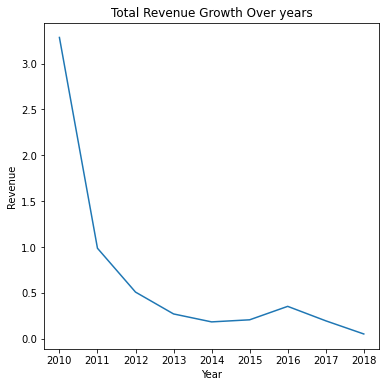

In [7]:
def plot_growth_yearly_revenue():
    Cumulative_Members_revenue_total, Cumulative_revenue_yearly = data_manipulation_for_revenue(subscriptions)
    plt.figure(figsize=(6,6))
    plt.plot(Cumulative_revenue_yearly['year'], Cumulative_revenue_yearly['Revenue_growth'])
    plt.title('Total Revenue Growth Over years')
    plt.ylabel('Revenue')
    plt.xlabel('Year')
  #  plt.axvline(x=2016, linestyle='--', color = 'r')
    plt.show()

plot_growth_yearly_revenue()    

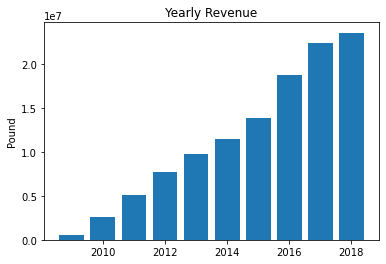

In [8]:
def plot_bar_yearly_revenue():
    Cumulative_Members_revenue_total, Cumulative_revenue_yearly = data_manipulation_for_revenue(subscriptions)
    r =  np.arange(2009,2019)
    Total_revenue = Cumulative_revenue_yearly['Total revenue']
    plt.ylabel('Pound')
    plt.bar(r, Total_revenue)
    plt.title('Yearly Revenue')
plot_bar_yearly_revenue()

### 2. Churn

### 2.1 Churn related basic functions

In [9]:
def add_count(join_date, duration, dates, members_count):
    index = (dates == join_date).argmax()
    
    for i in range(index,index + duration+1):
        members_count[i] = members_count[i] +1 
    
    return members_count

In [10]:
##create list with count of members in each month
def basic_data_manipulation_for_churn(subscriptions):

    #convert the join and end date to_date
    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
    
    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')

    ##we need to know each month kow many activemembers we have to calculate the churn 
    ##create the dataframe to help us calculate it
    customers_total = pd.DataFrame({'Date':dates})

    ##add total month membership in dataframe subscriptions
    subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                         (date_max - subscriptions['Join Date']), 
                                         (subscriptions['End Date'] - subscriptions['Join Date']) )
    ##convert the difference in months
    subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    
    return(subscriptions, dates)
    
    
def create_list_count_members_each_month(subsc_data):
  
    subscriptions  = subsc_data.copy()
    subscriptions, dates = basic_data_manipulation_for_churn(subscriptions)
    
    members_count =  [0] * len(dates)
    subscriptions.apply(lambda row: add_count(row['Join Date'], row['Duration'],
                                              dates, members_count), axis=1)
    customers_total = pd.DataFrame()
    customers_total['Date'] = dates
    customers_total['Members'] = members_count


    ## members join 
    join_frame = subscriptions.groupby(['Join Date']).count()['CustomerID'].reset_index()
    join_frame = join_frame.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
    customers_total = pd.merge(customers_total, join_frame, on = 'Date', how='outer')
    customers_total

    ##calulate membership growth =  number of new members subscription / total members
    customers_total['Membership Growth']= customers_total['New Members'] / (customers_total['Members'] - customers_total['New Members'])
    customers_total['Membership Growth'] =  customers_total['Membership Growth'].replace([np.inf, -np.inf], np.nan) 
    #customers_total


    ## members leave 
    end_frame = subscriptions.groupby(['End Date']).count()['CustomerID'].reset_index()
    end_frame = end_frame.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
    customers_total = pd.merge(customers_total, end_frame, on = 'Date', how='outer')
    #customers_total

    ##calulate churn =  number of ending subscription / total members
    customers_total['Churn']= customers_total['Cancellations'] / customers_total['Members']

    return customers_total

#customers_total = create_list_count_members_each_month(subscriptions)


def create_list_count_members_yearly(subsc_data):
   
    customers_total = create_list_count_members_each_month(subsc_data)
    customers_total['year'] =  pd.DatetimeIndex(customers_total['Date']).year
    customers_total_yearly = pd.DataFrame(customers_total.groupby('year').sum() )
    customers_total_yearly['Members growth'] = customers_total_yearly['Members'].pct_change()
    customers_total_yearly.reset_index(inplace=True)
    return customers_total_yearly


def plot_members_yearly(subsc_data):

    plt.figure(figsize=(6,10))
    customers_total_yearly = create_list_count_members_yearly(subsc_data)
    plt.plot(customers_total_yearly['year'], customers_total_yearly['Members growth'])
    plt.title('Total Memebrs Growth Over years')
    plt.ylabel('Memebers growth')
    plt.xlabel('Year')
    plt.axvline(x=2016, linestyle='--', color = 'r')
    plt.show()
    return

In [11]:
def plot_members_yearly_wrap():
    plot_members_yearly(subscriptions)

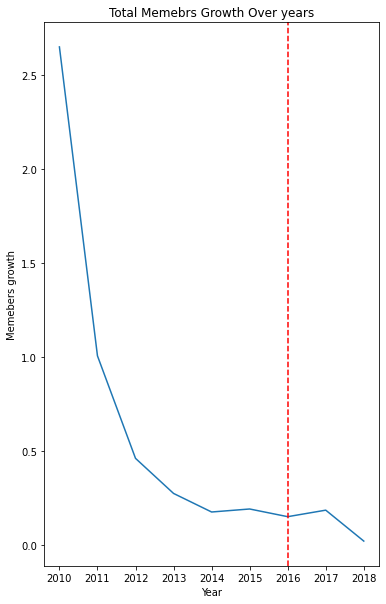

In [12]:
plot_members_yearly_wrap()

### 2.2 Churn total  functions

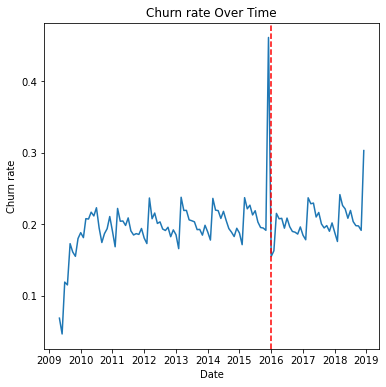

In [13]:
#Churn rate vs Time Graph
def plot_churn_total():
    plt.figure(figsize=(6,6))
    customers_total = create_list_count_members_each_month(subscriptions)
    plt.plot(customers_total['Date'], customers_total['Churn'])
    plt.title('Churn rate Over Time')
    plt.ylabel('Churn rate')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
plot_churn_total()

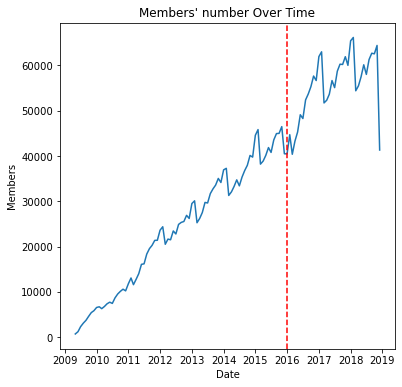

In [14]:
#Members number vs Time Graph
def plot_members_total():
    plt.figure(figsize=(6,6))
    customers_total = create_list_count_members_each_month(subscriptions)
    plt.plot(customers_total['Date'], customers_total['Members'])
    plt.title('Members\' number Over Time')
    plt.ylabel('Members')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
plot_members_total()

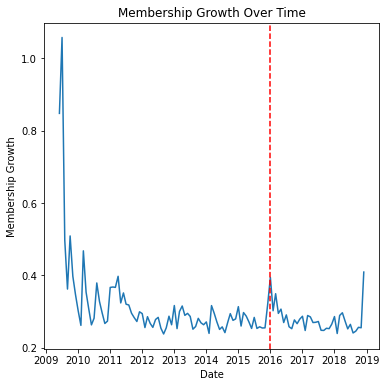

In [15]:
#Members number vs Time Graph
def plot_members_growth_total():
    plt.figure(figsize=(6,6))
    customers_total = create_list_count_members_each_month(subscriptions)
    plt.plot(customers_total['Date'], customers_total['Membership Growth'])
    plt.title('Membership Growth Over Time')
    plt.ylabel('Membership Growth')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
plot_members_growth_total()

### 2.3 Churn per population segments

In [16]:
#Churn population breakdown
def get_members_churn_growth(column_name, traits, subsc_data ):
   
    subscriptions  = subsc_data.copy()
    subscriptions, dates = basic_data_manipulation_for_churn(subscriptions)

    members_count_trait = {trait:([0]*len(dates))  for trait in traits}
    subscriptions_pertrait = subscriptions.groupby(subscriptions[column_name])
    for trait in traits:
        subscriptions_pertrait.get_group(trait).apply(lambda row : add_count(row['Join Date'], row['Duration'],
                                                       dates, members_count_trait[trait]), axis=1 )

    

    members_per_trait = pd.DataFrame({'Date':dates,column_name:traits[0], 'Members':members_count_trait[traits[0]]})

    for trait in traits[1:]:
        trait_list = [trait]*len(dates);
        trait_df = pd.DataFrame({'Date':dates, column_name:trait_list, 'Members':members_count_trait[trait]})
        members_per_trait = pd.merge(members_per_trait, trait_df, on = ['Date',column_name,'Members'], how='outer')

    members_per_trait['Members'] = members_per_trait['Members'].replace(0,np.nan)
    #members_per_trait.to_csv(r'members_per_trait.csv')

    ## members join per trait
    join_frame_trait = subscriptions.groupby(['Join Date', column_name]).count()['CustomerID'].reset_index()
    join_frame_trait = join_frame_trait.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
    members_per_trait = pd.merge(members_per_trait, join_frame_trait, on = ['Date', column_name], how='outer')

    ##calulate membership growth =  number of new members subscription / total members
    members_per_trait['Membership Growth']= members_per_trait['New Members'] / (members_per_trait['Members'] - members_per_trait['New Members'])
    members_per_trait['Membership Growth'] = members_per_trait['Membership Growth'].replace([np.inf, -np.inf], np.nan) 

    ## members leave per trait
    cancel_frame_trait = subscriptions.groupby(['End Date', column_name]).count()['CustomerID'].reset_index()
    cancel_frame_trait = cancel_frame_trait.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
    members_per_trait = pd.merge(members_per_trait, cancel_frame_trait, on = ['Date',column_name], how='outer')

    ##calulate churn =  number of ending subscription / total members
    members_per_trait['Churn']= members_per_trait['Cancellations'] / members_per_trait['Members']

    return members_per_trait

In [17]:
def plot_all_levels_(traits, members_per_trait, column_name, behaviour):
    plt.figure(figsize=(8,8))  
    for trait in traits:
        df_trait = members_per_trait[members_per_trait[column_name] == trait]
        plt.plot(df_trait["Date"], df_trait[behaviour], label = trait, alpha=0.7)
    plt.legend()

In [18]:
def plot_all_levels_churn(traits, members_per_trait, column_name):
    plot_all_levels_(traits, members_per_trait, column_name, "Churn")

In [19]:
def plot_all_levels_growth(traits, members_per_trait, column_name):
    plot_all_levels_(traits, members_per_trait, column_name, "Membership Growth")

In [20]:
def plot_all_levels_members_proportion(traits, members_per_trait, column_name):
    members_total = members_per_trait.groupby('Date')["Members"].sum().rename("Members_Total").reset_index()
    df = members_per_trait
    df = df.merge(members_total)
    df["Member proportion"] = df["Members"] / df["Members_Total"]

    plt.figure(figsize=(8,8))  
    for trait in traits:
        df_trait = df[df[column_name] == trait]
        plt.plot(df_trait["Date"], df_trait["Member proportion"], label = trait, alpha=0.7)
    plt.legend()

In [21]:
#gender trait
def get_gender_levels(subscriptions):
    genders = subscriptions.Gender.unique()
    members_per_gender = get_members_churn_growth('Gender', genders, subscriptions)
    return (genders, members_per_gender)

def plot_churn_by_gender():
    genders, members_per_gender = get_gender_levels(subscriptions)
    plot_all_levels_churn(genders, members_per_gender, 'Gender')

def plot_proportion_by_gender():
    genders, members_per_gender = get_gender_levels(subscriptions)
    plot_all_levels_members_proportion(genders, members_per_gender, 'Gender')

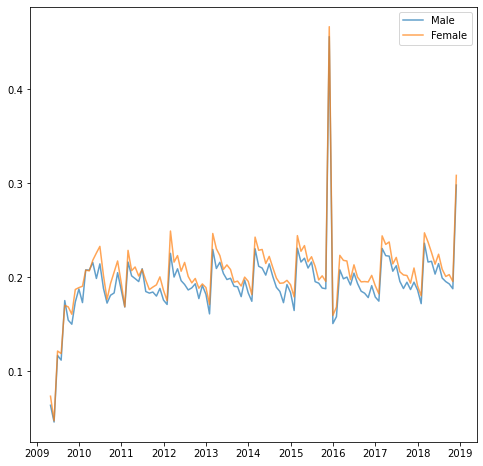

In [22]:
plot_churn_by_gender()

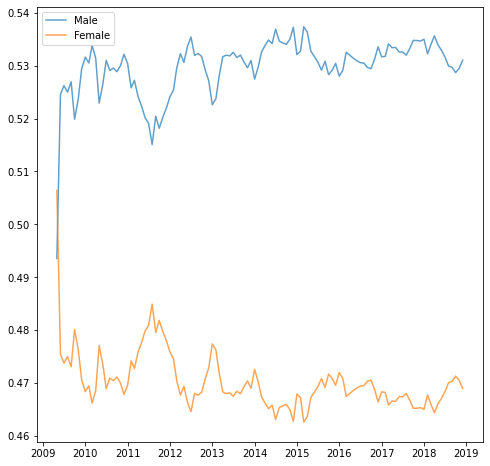

In [23]:
plot_proportion_by_gender()

In [24]:
#affluence trait
def get_affluence_levels(subscriptions):
    affluence_levels = subscriptions.Affluence.unique()
    members_per_affluence = get_members_churn_growth('Affluence', affluence_levels, subscriptions)
    return (affluence_levels, members_per_affluence)

def plot_churn_by_affluence():
    affluence_levels, members_per_affluence = get_affluence_levels(subscriptions)
    plot_all_levels_churn(affluence_levels, members_per_affluence, 'Affluence')

def plot_proportion_by_affluence():
    affluence_levels, members_per_affluence = get_affluence_levels(subscriptions)
    plot_all_levels_members_proportion(affluence_levels, members_per_affluence, 'Affluence')


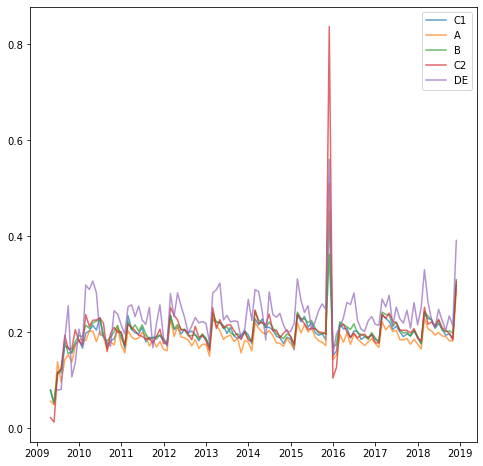

In [25]:
plot_churn_by_affluence()

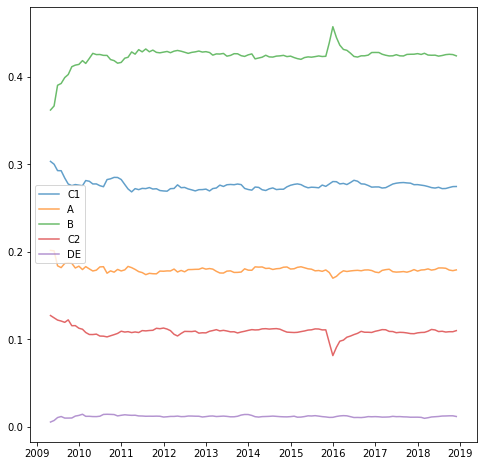

In [26]:
plot_proportion_by_affluence()

In [27]:
#Churn population breakdown
def get_members_churn_growth_age(column_name, traits, subsc_data ):
 
    subscriptions = subsc_data.copy()

    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')
    
    members_count_trait = {trait:([0]*len(dates))  for trait in traits}
    subscriptions_pertrait = subscriptions.groupby(subscriptions[column_name])
    for trait in traits:
        subscriptions_pertrait.get_group(trait).apply(lambda row : add_count(row['Join Date'], row['Duration'],
                                                       dates, members_count_trait[trait]), axis=1 )

    

    members_per_trait = pd.DataFrame({'Date':dates,column_name:traits[0], 'Members':members_count_trait[traits[0]]})

    for trait in traits[1:]:
        trait_list = [trait]*len(dates);
        trait_df = pd.DataFrame({'Date':dates, column_name:trait_list, 'Members':members_count_trait[trait]})
        members_per_trait = pd.merge(members_per_trait, trait_df, on = ['Date',column_name,'Members'], how='outer')

    members_per_trait['Members'] = members_per_trait['Members'].replace(0,np.nan)
    #members_per_trait.to_csv(r'members_per_trait.csv')

    ## members join per trait
    join_frame_trait = subscriptions.groupby(['Join Date', column_name]).count()['CustomerID'].reset_index()
    join_frame_trait = join_frame_trait.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
    members_per_trait = pd.merge(members_per_trait, join_frame_trait, on = ['Date', column_name], how='outer')

    ##calulate membership growth =  number of new members subscription / total members
    members_per_trait['Membership Growth']= members_per_trait['New Members'] / (members_per_trait['Members'] - members_per_trait['New Members'])
    members_per_trait['Membership Growth'] = members_per_trait['Membership Growth'].replace([np.inf, -np.inf], np.nan) 

    ## members leave per trait
    cancel_frame_trait = subscriptions.groupby(['End Date', column_name]).count()['CustomerID'].reset_index()
    cancel_frame_trait = cancel_frame_trait.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
    members_per_trait = pd.merge(members_per_trait, cancel_frame_trait, on = ['Date',column_name], how='outer')

    ##calulate churn =  number of ending subscription / total members
    members_per_trait['Churn']= members_per_trait['Cancellations'] / members_per_trait['Members']

    return members_per_trait

In [28]:
#Age buckets
def define_age_buckets_and_tier_col():

    
    subscriptions = pd.read_csv( 'subscriptionsdataFINAL.csv') 

    #convert the join and end date to_date
    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
    
    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')

    ##we need to know each month kow many activemembers we have to calculate the churn 
    ##create the dataframe to help us calculate it
    customers_total = pd.DataFrame({'Date':dates})

    ##add total month membership in dataframe subscriptions
    subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                         (date_max - subscriptions['Join Date']), 
                                         (subscriptions['End Date'] - subscriptions['Join Date']) )
    ##convert the difference in months
    subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    

    subscriptions['Join Age'] = pd.DatetimeIndex(subscriptions["Join Date"]).year - subscriptions["BirthYear"]
    subscriptions['End Age'] = np.where(subscriptions['End Date'].isna(),
                                ((date_max.year - subscriptions['BirthYear']) ), 
                               (pd.DatetimeIndex(subscriptions['End Date']).year - subscriptions['BirthYear']) ).astype(int)
  
        
    age_limits = [24, 30, 40]
    conditions = [
        (subscriptions['Join Age'] <= age_limits[0]),
        (subscriptions['Join Age'] > age_limits[0]) & (subscriptions['Join Age'] <= age_limits[1]),
        (subscriptions['Join Age'] > age_limits[1]) & (subscriptions['Join Age'] <= age_limits[2]),
        (subscriptions['Join Age'] > age_limits[2])     ]

    # create a list of the values we want to assign for each condition
    values = ['18-24', '25-30', '31-40', '40+']

    
    subscriptions['Join Age Tier'] = np.select(conditions, values)
    subscriptions.groupby('Join Age Tier').count()
    
    return subscriptions    

In [29]:
def plot_churn_by_age():  
    subscriptions = define_age_buckets_and_tier_col()
    age = subscriptions['Join Age Tier'].unique()
    members_per_age = get_members_churn_growth_age('Join Age Tier', age,subscriptions )
    plot_all_levels_churn(age, members_per_age, 'Join Age Tier')

def plot_proportion_by_age():
    subscriptions = define_age_buckets_and_tier_col()
    age = subscriptions['Join Age Tier'].unique()
    members_per_age = get_members_churn_growth_age('Join Age Tier', age, subscriptions)
    plot_all_levels_members_proportion(age, members_per_age, 'Join Age Tier')
    
def plot_growth_by_age():
    subscriptions = define_age_buckets_and_tier_col()
    age = subscriptions['Join Age Tier'].unique()
    members_per_age = get_members_churn_growth_age('Join Age Tier', age, subscriptions)
    plot_all_levels_growth(age, members_per_age, 'Join Age Tier')

In [30]:
def plot_churn_by_age_wrap():
     plot_churn_by_age()

In [31]:
def plot_proportion_by_age_wrap():
    plot_proportion_by_age()

In [32]:
def plot_growth_by_age_wrap():
    plot_growth_by_age()

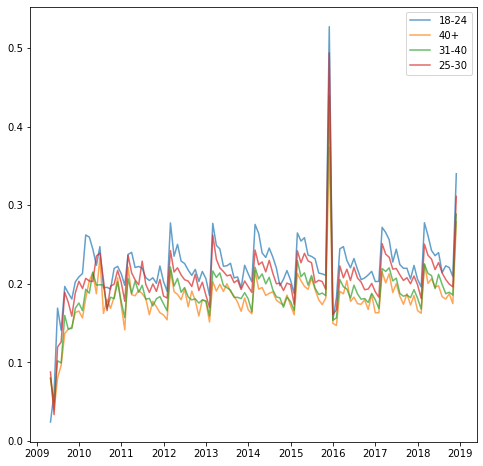

In [33]:
plot_churn_by_age_wrap()

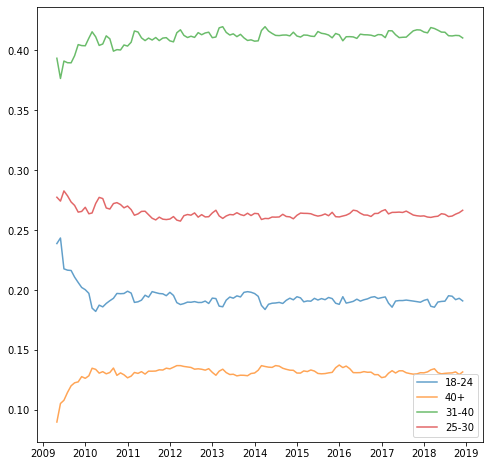

In [34]:
plot_proportion_by_age_wrap()

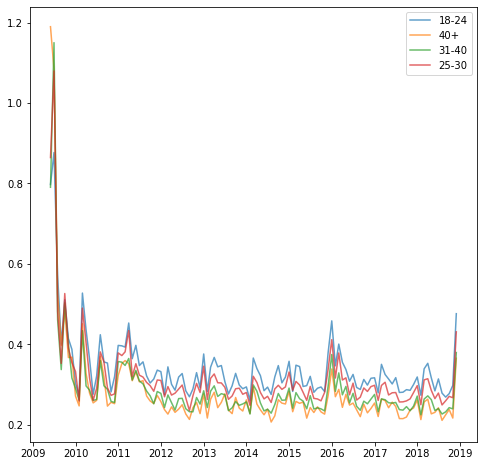

In [35]:
plot_growth_by_age()

In [36]:
#Subscrition trait
def get_subscription_type_levels(subscriptions):
    subc_types = subscriptions['Subscription Type'].unique()
    members_per_subc_types = get_members_churn_growth('Subscription Type', subc_types, subscriptions)
    return (subc_types, members_per_subc_types)

def plot_churn_by_subscription_type():
    subc_types, members_per_subc_types = get_subscription_type_levels(subscriptions)
    plot_all_levels_churn(subc_types, members_per_subc_types, 'Subscription Type')
    
def plot_proportion_by_subscription_type():
    subc_types, members_per_subc_types = get_subscription_type_levels(subscriptions)
    plot_all_levels_members_proportion(subc_types, members_per_subc_types, 'Subscription Type')

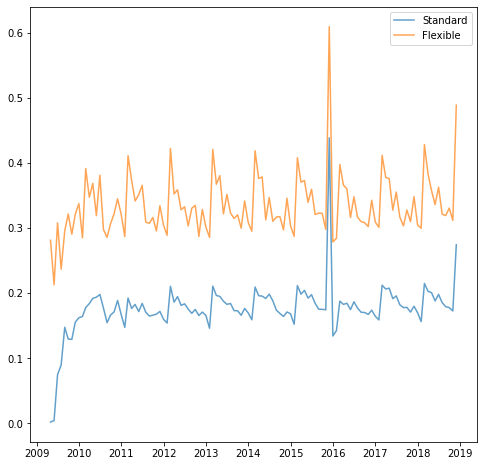

In [37]:
plot_churn_by_subscription_type()

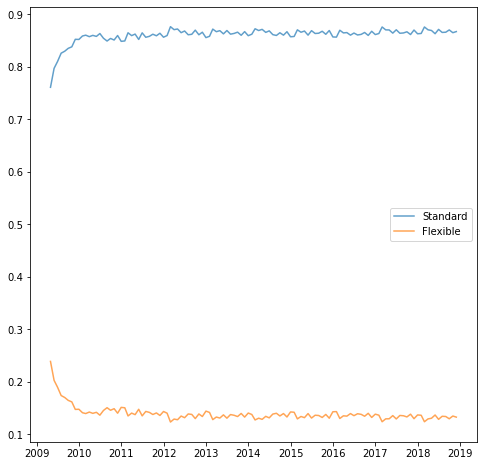

In [38]:
plot_proportion_by_subscription_type()

## 3. Memebership by segmentation

In [39]:
def data_manipulation_membership(subscr_data,col_name = ' '):
    
    subscriptions = subscr_data.copy()
   
    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)

    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    
    subscriptions['End Date'] = subscriptions['End Date'].fillna(date_max)
    subscriptions[all_dates] = pd.concat([((subscriptions['Join Date'] <= i) & (i <= subscriptions['End Date'])).astype(int) for i in all_dates], axis=1)
    
    if col_name!='':
        ds = subscriptions.groupby(col_name)[all_dates].sum().T 
    else:
        ds = subscriptions[all_dates].sum().T 
        
    return ds
        
def plot_affluence(col_name = ' '):
    ds = data_manipulation_membership(subscriptions,col_name)
    ds.plot()
    plt.title('Total Active Member')
    plt.xlabel('Year')
    plt.ylabel('Number of Active Members')
    plt.show()
    
    ds = (ds-ds.shift(1))/ds.shift(1)
    ds.plot()
    plt.title('Membership Growth Rate')
    plt.xlabel('Year')
    plt.ylabel('Membership Growth Rate')
    plt.show()

In [40]:
def plot_affluence_wrap():
    plot_affluence('Affluence')

In [41]:
def data_manipulation_age(subscr_data, col_name = ''):
    # join and end age
    subscriptions = subscr_data.copy()

    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)

    
    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    
    subscriptions["Join Age"] = pd.DatetimeIndex(subscriptions["Join Date"]).year - subscriptions["BirthYear"]
    subscriptions['End Age'] = np.where(subscriptions['End Date'].isna(),
                                ((date_max.year - subscriptions['BirthYear']) ), 
                                (pd.DatetimeIndex(subscriptions['End Date']).year - subscriptions['BirthYear']) ).astype(int)
    #define age buckets
    age_limits = [24, 30, 40]

    conditions = [
    (subscriptions['Join Age'] <= age_limits[0]),
    (subscriptions['Join Age'] > age_limits[0]) & (subscriptions['Join Age'] <= age_limits[1]),
    (subscriptions['Join Age'] > age_limits[1]) & (subscriptions['Join Age'] <= age_limits[2]),
    (subscriptions['Join Age'] > age_limits[2])     ]

    # create a list of the values we want to assign for each condition
    values = ['24', '24-30', '30-40', '40']

    subscriptions['Join Age Tier'] = np.select(conditions, values)
    
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    subscriptions['End Date'] = subscriptions['End Date'].fillna(date_max)
    subscriptions[all_dates] = pd.concat([((subscriptions['Join Date'] <= i) & (i <= subscriptions['End Date'])).astype(int) for i in all_dates], axis=1)

    
    ds = pd.DataFrame()
    if col_name!='':
        ds = subscriptions.groupby(col_name)[all_dates].sum().T 
    else:
        ds = subscriptions[all_dates].sum().T 
    return ds
    
def plot_age(subscriptions, col_name = ''):
    ds = data_manipulation_age(subscriptions, col_name)
    
    ds.plot()
    plt.title('Total Active Member')
    plt.xlabel('Year')
    plt.ylabel('Number of Active Members')
    plt.show()
    
    ds = (ds-ds.shift(1))/ds.shift(1)
    ds.plot()
    plt.title('Membership Growth Rate')
    plt.xlabel('Year')
    plt.ylabel('Membership Growth Rate')
    plt.show()

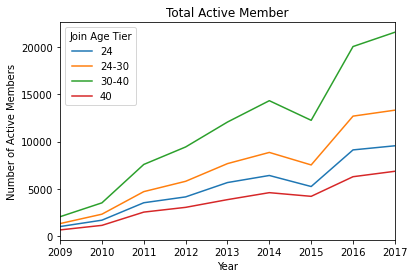

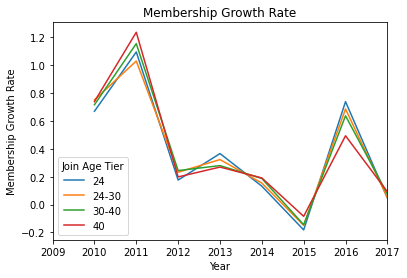

In [42]:
plot_age(subscriptions,'Join Age Tier')

## 4. Duration analysis Graph  by year

In [43]:
subscriptions_duration= subscriptions.copy()
subscriptions_duration['Join Date'] =  pd.to_datetime(subscriptions_duration['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions_duration['End Date'] =  pd.to_datetime(subscriptions_duration['End Date'].str.upper(), format='%b-%y', yearfirst=False)

#Calculation of Duration
def duration_calc(subscriptions_duration):
    
    date_min = min (subscriptions_duration['Join Date'].min(),subscriptions_duration['End Date'].min() )
    date_max = max (subscriptions_duration['Join Date'].max(),subscriptions_duration['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')
    print(date_min)
    
    subscriptions_duration['Duration'] = np.where(subscriptions_duration['End Date'].isna(), 
                                           (date_max - subscriptions_duration['Join Date']), 
                                           (subscriptions_duration['End Date'] - subscriptions_duration['Join Date']) )
    subscriptions_duration['Duration'] = (subscriptions_duration['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    duration= subscriptions_duration.groupby(['Join Date', 'Duration']).size().to_frame('Count').reset_index()


    #import pandas as pd_frame('Count').reset_index()
    return duration

2009-05-01 00:00:00


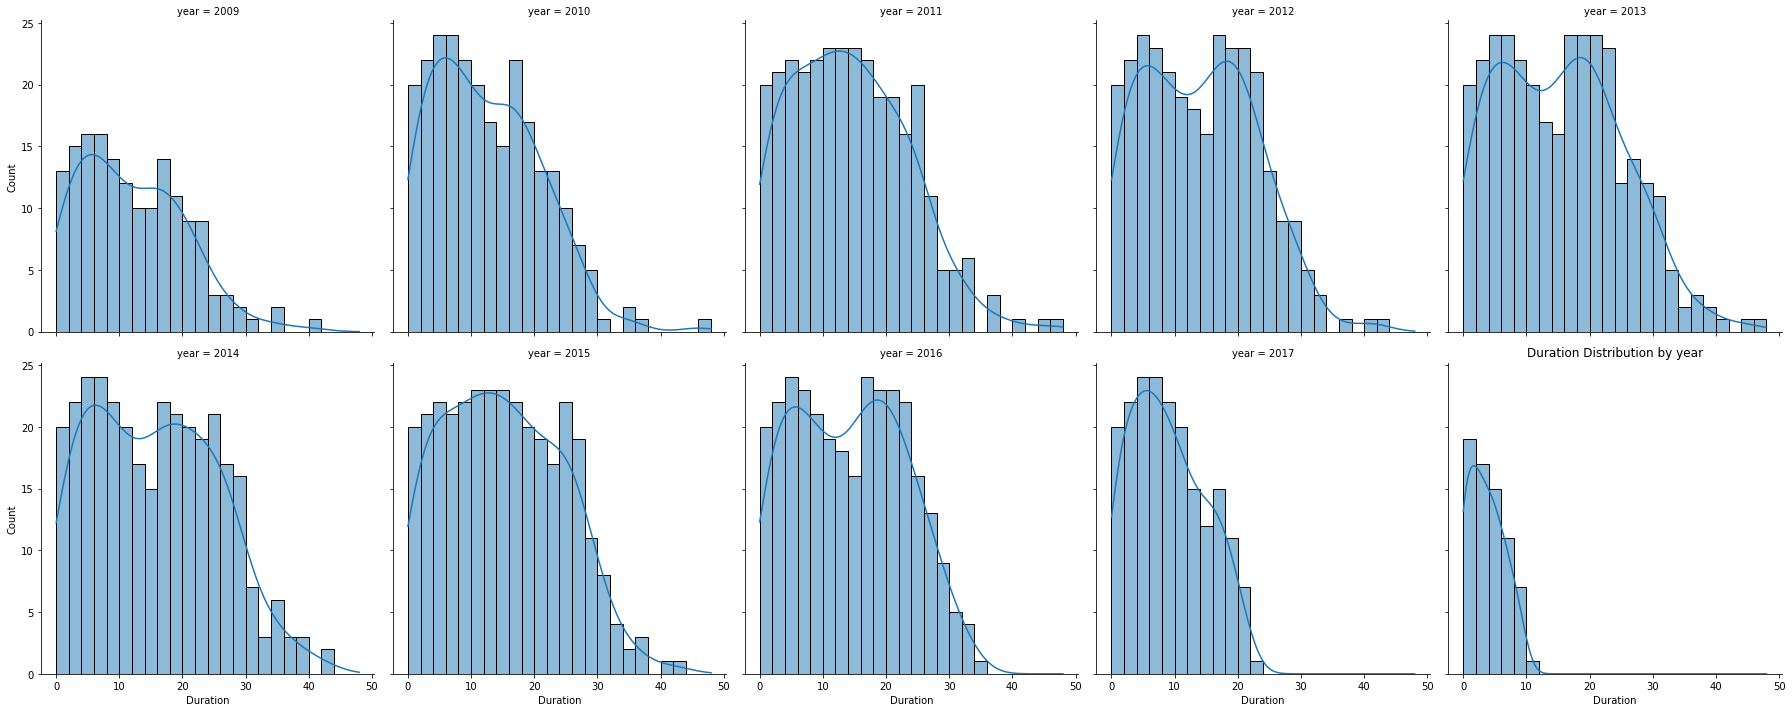

In [44]:
#Duration distribution by year graph
def duration_dis_plot():
    duration= duration_calc(subscriptions_duration)
    duration['year']=duration['Join Date'].dt.year
    sns.displot(duration, x="Duration",kde=True, col='year',col_wrap=5)
    plt.title('Duration Distribution by year')
    plt.show()
    
duration_dis_plot()

2009-05-01 00:00:00


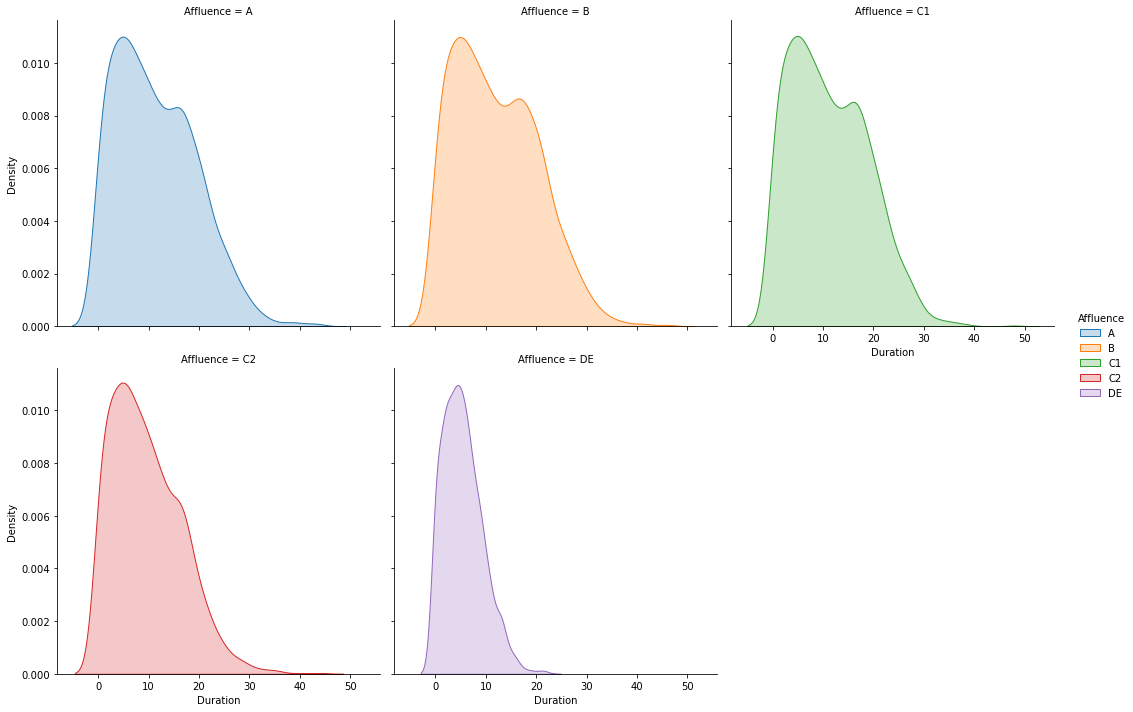

In [45]:
def duration_affluence_plot():
    duration= duration_calc(subscriptions_duration)
    duration= subscriptions_duration.groupby(['Join Date', 'Duration','Affluence']).size().to_frame('Count').reset_index()
    sns.displot(duration, x="Duration",col= "Affluence",hue='Affluence',col_wrap=3,kind="kde", fill=True)
    
duration_affluence_plot()

2009-05-01 00:00:00


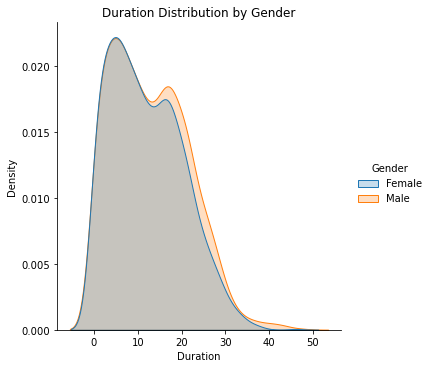

In [46]:
def duration_gender_plot():
    duration= duration_calc(subscriptions_duration)
    duration= subscriptions_duration.groupby(['Join Date', 'Duration','Gender']).size().to_frame('Count').reset_index()
    sns.displot(duration, x="Duration",hue='Gender',kind="kde", fill=True)
    plt.title('Duration Distribution by Gender')

duration_gender_plot()

2009-05-01 00:00:00


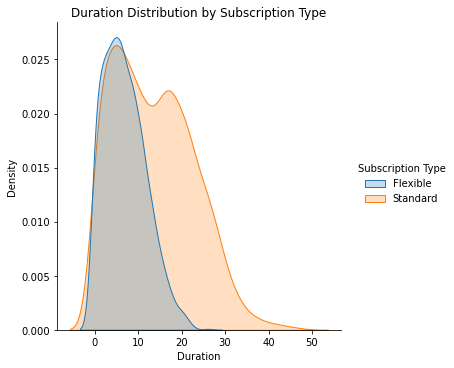

In [47]:
def duration_subscription_type_plot():
    duration= duration_calc(subscriptions_duration)
    duration= subscriptions_duration.groupby(['Join Date', 'Duration','Subscription Type']).size().to_frame('Count').reset_index()
    sns.displot(duration, x="Duration",hue='Subscription Type',kind="kde", fill=True)
    plt.title('Duration Distribution by Subscription Type')

duration_subscription_type_plot()

## 5. Behaviour by season

In [48]:
#Merging the visitation and subscriptions data together
def merging_data():
    visit1=visitation_part1#.copy()
    visit2=visitation_part2#.copy()
    visitdf = pd.concat([visit1, visit2], axis=0, join='inner')
    all_data= pd.merge( left= subscriptions, right= visitdf, left_on='CustomerID', right_on='CustomerID')
    all_data['visitdate'] =  pd.to_datetime(all_data['visitdate'].str.upper(), format='%Y/%m/%d', yearfirst=False)
    all_data['month'] = all_data['visitdate'].dt.month
    return all_data

In [49]:
#Classifying season
def classify_season(month):
    if  month==6 or month==7 or month==8:
        return 'Summer'
    elif month==9 or month==10 or month==11:
        return 'Autumn'
    elif month==12 or month==1 or month==2:
        return 'Winter'
    else:
        return 'Spring'

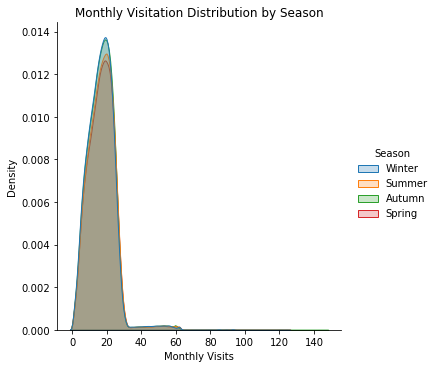

In [50]:
# Plot for monthly visitations by season:
def plot_season():
    all_data = merging_data()
    all_data['Season'] = all_data['month'].apply(lambda x : classify_season(x))
    freq=all_data.groupby(['CustomerID','month','Season']).size().to_frame('Monthly Visits').reset_index()
    sns.displot(freq, x="Monthly Visits",hue='Season',kind="kde", bw_adjust=1.5, fill=True)
    plt.title('Monthly Visitation Distribution by Season')
    
plot_season()

## 6. Customer Profile

In [51]:
#Calculating active members
def active_members(subscr_data):
    subscriptions  =  subscr_data.copy()

    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)

    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )

    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    subscriptions['End Date'] = subscriptions['End Date'].fillna(date_max)
    subscriptions[all_dates] = pd.concat([((subscriptions['Join Date'] <= i) &
                                           (i <= subscriptions['End Date'])).astype(int) for i in all_dates], axis=1)
    return subscriptions    

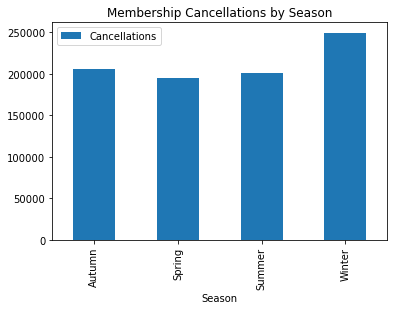

In [52]:
#Data for seasonal cancellations
def cancellations_season_data():
    
    subscriptions = pd.read_csv( 'subscriptionsdataFINAL.csv')
    df = active_members(subscriptions)
    df['month'] = pd.DatetimeIndex(df['End Date']).month
    df['year'] = pd.DatetimeIndex(df['End Date']).year
    df['Season'] = df['month'].apply(lambda x : classify_season(x))
    season=df.groupby(['year','Season']).size().to_frame('Cancellations').reset_index()
    season1= season.groupby(['Season']).sum().reset_index()
    return season1

#seasonal cancellations plot
def seasonal_cancellations_plot():
    season1= cancellations_season_data()
    season1.plot.bar(x='Season', y='Cancellations')
    plt.title('Membership Cancellations by Season')

seasonal_cancellations_plot()

## 7. k-Nearest Neighbour Model

In [9]:
def change_timestamp(subscriptions_Q5):
    subscriptions_1 = subscriptions_Q5.copy()
    subscriptions_1['Join Date'] =  pd.to_datetime(subscriptions_1['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions_1['Join_year'] = pd.DatetimeIndex(subscriptions_1['Join Date']).year
    subscriptions_1['End Date'] =  pd.to_datetime(subscriptions_1['End Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions_1.dropna()
    return subscriptions_1

def add_duration(subscriptions_1):
    subscriptions_2 = subscriptions_1.copy()
    date_min = min (subscriptions_2['Join Date'].min(),subscriptions_2['End Date'].min() )
    date_max = max (subscriptions_2['Join Date'].max(),subscriptions_2['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')
    subscriptions_2['Duration'] = np.where(subscriptions_2['End Date'].isna(), 
                                         (date_max - subscriptions_2['Join Date']), 
                                         (subscriptions_2['End Date'] - subscriptions_2['Join Date']) )
    subscriptions_2['Duration'] = (subscriptions_2['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    return subscriptions_2

def add_type_of_customer(subscriptions_2):
    subscriptions_3= subscriptions_2.copy()
    visitation_part1_peakvisit = visitation_part1.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
    visitation_part2_peakvisit = visitation_part2.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
    visitation_peakvisit = pd.merge(visitation_part1_peakvisit,visitation_part2_peakvisit,on='CustomerID',how='outer').sort_index().replace({np.nan:0})
    visitation_peakvisit['False'] = visitation_peakvisit['False_x'] + visitation_peakvisit['False_y']
    visitation_peakvisit['True'] = visitation_peakvisit['True_x'] + visitation_peakvisit['True_y']
    visitation_peakvisit=visitation_peakvisit.drop(columns=['False_x','True_x','False_y','True_y'])
    visitation_peakvisit['Peak_proportion'] = visitation_peakvisit['True']/(visitation_peakvisit['True'] + visitation_peakvisit['False'])
    def classify_peak(Peak_proportion):
        if Peak_proportion < 0.35:
            return 'Off_Peak_Customer'
        elif 0.25 <= Peak_proportion < 0.65:
            return 'Average'
        else:
            return 'Peak_Customer'
    visitation_peakvisit['Peak_categogy'] = visitation_peakvisit['Peak_proportion'].apply(lambda x : classify_peak(x))
    return subscriptions_3,visitation_peakvisit

def plot_KNN_model(size_dataset,k_value):
    subscriptions_1 = change_timestamp(subscriptions_Q5)
    subscriptions_2 = add_duration(subscriptions_1)
    subscriptions_3,visitation_peakvisit = add_type_of_customer(subscriptions_2)
    subscriptions_3 = pd.merge(subscriptions_3,visitation_peakvisit['Peak_categogy'],on='CustomerID',how='outer')
    subscriptions_3 = subscriptions_3[:size_dataset]
    subscriptions_4=subscriptions_3.copy().drop(columns=['End Date','CustomerID'])
    def normalises_string(data,data_list):
        index = data_list.index(data)
        return index
    for column in subscriptions_4.columns:
        if column != 'Duration':
            subscriptions_4[column] = subscriptions_4.apply(lambda row: normalises_string(row[column], list(subscriptions_4[column].unique())),axis=1)
    if size_dataset == 800:
        training_data, validation_data, test_data = subscriptions_4[:400], subscriptions_4[400:600], subscriptions_4[600:] 
    else: #data_set = 4000
        training_data, validation_data, test_data = subscriptions_4[:2000], subscriptions_4[2000:3000], subscriptions_4[3000:] 
    def normalises_the_data_z_score(input_data):
        data_normalised = preprocessing.scale(input_data)
        data_normalised = pd.DataFrame(data=data_normalised,columns = list(input_data.columns))
        data_normalised['Duration'] = input_data['Duration']
        return data_normalised
    training_data_normalised = normalises_the_data_z_score(training_data)
    validation_data_normalised = normalises_the_data_z_score(validation_data)
    test_data_normalised = normalises_the_data_z_score(test_data)
    training_data_normalised_x = training_data_normalised.copy().drop(columns=['Duration']).values
    training_data_normalised_y = training_data['Duration']

    validation_data_normalised_x = validation_data_normalised.copy().drop(columns=['Duration']).values
    validation_data_normalised_y = validation_data['Duration']
    scores_list = []
    for k in range(1,k_value):
       classifier = KNeighborsClassifier(n_neighbors=k)
       classifier.fit(training_data_normalised_x, training_data_normalised_y)
       validation_data_normalised_y_predicted = classifier.predict(validation_data_normalised_x)
       scores_list.append(1-metrics.accuracy_score(validation_data_normalised_y,validation_data_normalised_y_predicted,normalize=True))
    scores_list_df = pd.DataFrame(data=scores_list).rename(columns={0: "Classificaion error(validation data)"})
    scores_list_df['k-value'] = list(range(1,k_value))
    scores_list = []
    # The part below is to use the trainning data to predict the training data.
    for k in range(1,k_value):
       classifier = KNeighborsClassifier(n_neighbors=k)
       classifier.fit(training_data_normalised_x, training_data_normalised_y)
       training_data_normalised_y_predicted = classifier.predict(training_data_normalised_x)
       scores_list.append(1-metrics.accuracy_score(training_data_normalised_y,training_data_normalised_y_predicted,normalize=True))
    scores_list_df['Classificaion error(training data)'] = scores_list
    plt.plot(scores_list_df['k-value'], scores_list_df['Classificaion error(validation data)'], label = "Validation data")
    plt.gca().invert_xaxis()
    if size_dataset==800:
        plt.title('Classification error, 800 rows, k=1-100')
    else:
        plt.title('Classification error, 4000 rows, k=1-200')
    plt.ylabel('%')
    plt.legend()

def plot_KNN_model_800():
    plot_KNN_model(800,101)
    
def plot_KNN_model_4000():
    plot_KNN_model(4000,201)


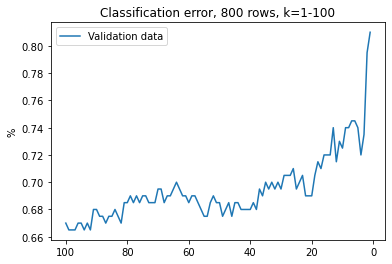

In [10]:
plot_KNN_model_800()

In [20]:
def plot_active_member_bar_line():
    df = subscriptions_Q5.copy()
    df['Join Date'] =  pd.to_datetime(df['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    df['Join_year'] = pd.DatetimeIndex(df['Join Date']).year
    df['End Date'] =  pd.to_datetime(df['End Date'].str.upper(), format='%b-%y', yearfirst=False)
    df.dropna()
    
    date_min = min (df['Join Date'].min(),df['End Date'].min() )
    date_max = max (df['Join Date'].max(),df['End Date'].max() )
    df['Duration'] = np.where(df['End Date'].isna(), 
                                         (date_max - df['Join Date']), 
                                         (df['End Date'] - df['Join Date']) )
    df['Duration'] = (df['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    df.loc[(df.Duration <= 2),'Duration']=2
    def extend_early_standard_to_three_months(join_date,duration):
        return join_date + pd.DateOffset(months=duration)
    df['End Date']=df.apply(lambda row: extend_early_standard_to_three_months(row['Join Date'], row['Duration']),axis=1)
    df=df.drop(columns=['Duration'])
    
    numbers_club = pd.DataFrame(df.groupby('Join_year')['Club'].nunique())
    numbers_club['Growth']=numbers_club['Club'].pct_change()
    member_joined_data = subscriptions.groupby(['Join Date','Subscription Type']).size().reset_index(name='Number_of_member_joined')
    member_joined_data = member_joined_data.rename(columns={'Join Date': "Date"})
    member_left_data = subscriptions.groupby(['End Date','Subscription Type']).size().reset_index(name='Number_of_member_left')
    member_left_data=member_left_data.rename(columns={'End Date': "Date"})
    member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)
    member_data = pd.merge(member_joined_data,member_left_data,on = ['Subscription Type','Date'],how='outer').sort_index().replace({np.nan:0})
    member_data['net_member'] = member_data['Number_of_member_joined'] - member_data['Number_of_member_left'] 
    member_data = member_data.drop(columns = ['Number_of_member_joined', 'Number_of_member_left'])
    Cumulative_Members = pd.DataFrame(member_data.groupby(['Date']).sum('net_member').unstack(fill_value=0))
    Cumulative_Members = Cumulative_Members.rename(columns={0: "Cumulative_members"})
    Cumulative_Members = Cumulative_Members.cumsum().reset_index()
    Cumulative_Members_yearly = Cumulative_Members.copy()
    Cumulative_Members_yearly['year'] = pd.DatetimeIndex(Cumulative_Members_yearly['Date']).year
    Cumulative_Members_yearly=Cumulative_Members_yearly.groupby(['year']).sum()
    Cumulative_Members_yearly=Cumulative_Members_yearly.drop([2019])
    Cumulative_Members_yearly['Cumulative_members_Grwoth']=Cumulative_Members_yearly['Cumulative_members'].pct_change()
    Cumulative_Members_seperating = pd.DataFrame(member_data.groupby(['Date','Subscription Type']).sum('net_member').unstack(fill_value=0))
    Cumulative_Members_seperating = Cumulative_Members_seperating.rename(columns={0: "Cumulative_members"})
    Cumulative_Members_seperating = Cumulative_Members_seperating.cumsum().reset_index()
    x = Cumulative_Members_seperating['net_member']
    y = pd.DataFrame({'Date':Cumulative_Members_seperating['Date']})
    y['Flexible']=x['Flexible']
    y['Standard']=x['Standard']
    Cumulative_Members_seperating=y
    def calculate_revenue_flexible(Date,net_member):
        date_while_price_changed = pd.Timestamp('2016-01-01') 
        if Date < date_while_price_changed:
            return net_member * 25.99
        elif Date >= date_while_price_changed:
            return net_member * 30.99
    def calculate_revenue_standard(Date,net_member):
        date_while_price_changed = pd.Timestamp('2016-01-01') 
        if Date < date_while_price_changed:
            return net_member * 20.99
        elif Date >= date_while_price_changed:
            return net_member * 26.99 
    Cumulative_Members_seperating_revenue = Cumulative_Members_seperating.copy()
    Cumulative_Members_seperating_revenue['Flexible_revenue']=Cumulative_Members_seperating_revenue.apply(lambda row: calculate_revenue_flexible(row['Date'], row['Flexible']),axis=1)
    Cumulative_Members_seperating_revenue['Standard_revenue']=Cumulative_Members_seperating_revenue.apply(lambda row: calculate_revenue_standard(row['Date'], row['Standard']),axis=1)
    Cumulative_Members_seperating_revenue['Total_revenue']=Cumulative_Members_seperating_revenue['Flexible_revenue'] + Cumulative_Members_seperating_revenue['Standard_revenue']
    Cumulative_Members_seperating_revenue_yearly = Cumulative_Members_seperating_revenue.copy()
    Cumulative_Members_seperating_revenue_yearly['year'] = pd.DatetimeIndex(Cumulative_Members_seperating_revenue_yearly['Date']).year
    Cumulative_Members_seperating_revenue_yearly=Cumulative_Members_seperating_revenue_yearly.groupby(['year']).sum()
    Cumulative_Members_seperating_revenue_yearly=Cumulative_Members_seperating_revenue_yearly.drop([2019])
    Cumulative_Members_seperating_revenue_yearly['Revenue_grwoth']=Cumulative_Members_seperating_revenue_yearly['Total_revenue'].pct_change()



    Cumulative_Members_noseperating_revenue_yearly = Cumulative_Members_seperating_revenue_yearly.copy()
    Cumulative_Members_noseperating_revenue_yearly['TotalMember'] = Cumulative_Members_seperating_revenue_yearly['Flexible'] + Cumulative_Members_seperating_revenue_yearly['Standard']
    Cumulative_Members_noseperating_revenue_yearly['MemberGrowth'] = Cumulative_Members_noseperating_revenue_yearly['TotalMember'].pct_change()
    r =  np.arange(2009,2019)
    TotalMember = Cumulative_Members_noseperating_revenue_yearly['TotalMember']
    MemberGrowth = Cumulative_Members_noseperating_revenue_yearly['MemberGrowth']
    ax=Cumulative_Members_noseperating_revenue_yearly['TotalMember'].plot(kind='bar',label='Cumulative Active Member')
    plt.legend(bbox_to_anchor=(0.2, 0.75, 1, 0.75), loc='lower left')
    ax2 = ax.twinx()
#     Cumulative_Members_noseperating_revenue_yearly['MemberGrowth'].plot(kind='line')
    ax2.plot(Cumulative_Members_noseperating_revenue_yearly[['MemberGrowth']].values,label='Growth Rate of Member')
    plt.legend(bbox_to_anchor=(0.2, 0.85, 1, 0.85), loc='lower left')
    plt.title('Cumulative Active Member and Growth')
    

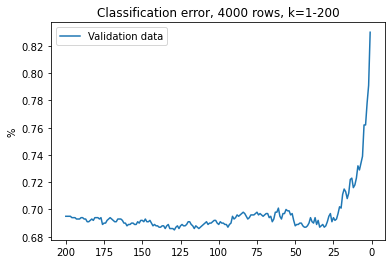

In [12]:
plot_KNN_model_4000()

In [21]:
plot_active_member_bar_line()    

TypeError: can only concatenate str (not "DateOffset") to str

### Number of clubs overitme

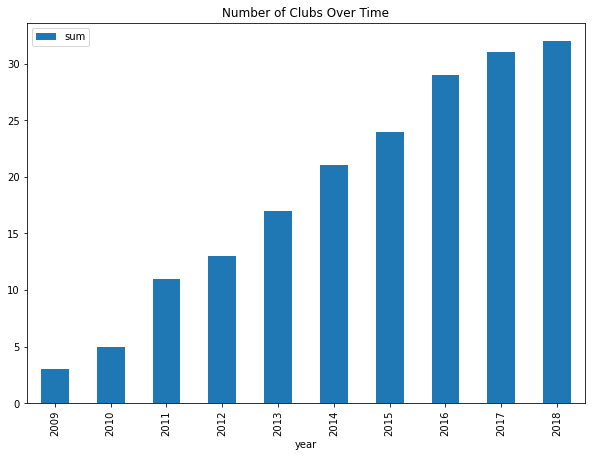

In [72]:
def number_of_clubs():
    subs_data = subscriptions.copy()

    df=active_members(subs_data)
    df['year'] = df['Join Date'].dt.year
    df11=df.groupby(['Club','year']).size().to_frame('Count').reset_index()
    df_club=df11.groupby(['Club','year']).size().to_frame('Count').reset_index()
    pivotdata = df_club.pivot(index= 'year', columns='Club', values='Count')
    pivotdata["sum"] = pivotdata.sum(axis=1)
    plotdata=pivotdata.reset_index()
    return plotdata

def club_plot():
    plotdata= number_of_clubs()
    plotdata.plot.bar(x='year', y='sum', figsize=(10,7))
    plt.title('Number of Clubs Over Time')
    
club_plot()

In [22]:
member_left_data

NameError: name 'member_left_data' is not defined